# Embedding Transformed Data

In [1]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime
import os

from ripser import Rips

# My stuff
from base_config import BaseConfig
from handler import *

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from jupyterthemes import jtplot
jtplot.style(ticks=True, grid=True, gridlines='--')

### Global Parameters and Dataset Prep

In [2]:
metric = 'Global_active_power'

In [3]:
cfg = BaseConfig(
    dataPath='./data',
    outPath='./out',
    runId='TEST',
    metric=metric,
    minDateData=None,
    maxDateData=None,
    numDaysPred=365,
)

<AxesSubplot:xlabel='Date'>

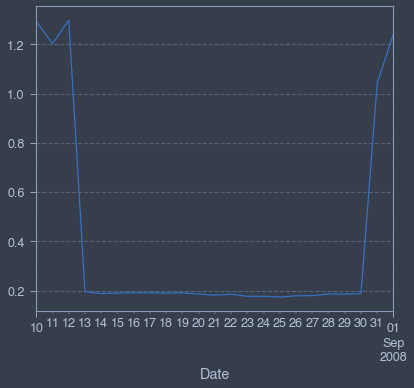

In [4]:
cfg.dataset.loc['2008-08-10':'2008-09-01', metric].plot() # Need to patch these days

In [5]:
cfg.patchSeries('2008-08-13', '2008-08-30')

In [6]:
dataset = cfg.dataset

In [7]:
firstDayTrain = '2006-12-16'
firstDayPred = '2010-12-12'

### Original Time Series

In [8]:
dataset['RollingMetric'] = dataset[metric].rolling(7, center=True).mean()

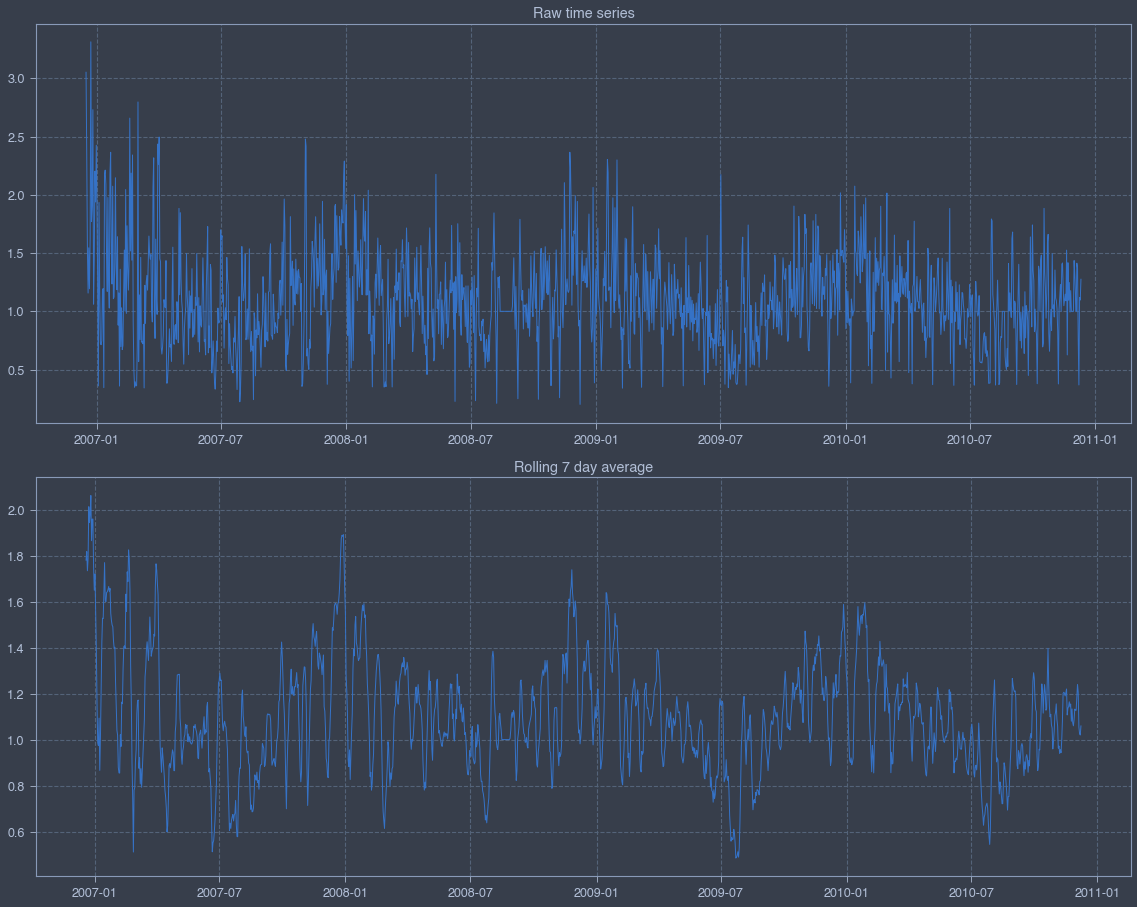

In [9]:
f, axes = plt.subplots(2, 1, figsize=(16, 12.8))
axes[0].plot(dataset.index, dataset[metric], linewidth=1)
axes[0].set_title('Raw time series')
axes[1].plot(dataset.index, dataset['RollingMetric'], linewidth=1)
axes[1].set_title('Rolling 7 day average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

## Fit Global Trend

In [10]:
Y = dataset['RollingMetric'].loc[firstDayTrain:].dropna()

In [11]:
power = 1
globalSlope = 0
globalIntercept = Y.mean()
fitLinearTrend = pd.Series(globalIntercept, index=Y.index)

Text(0.5, 1.0, 'Series vs global mean')

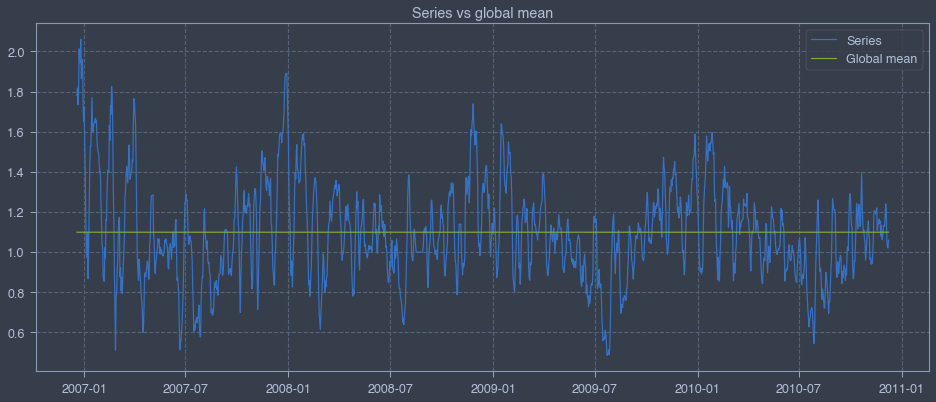

In [12]:
plt.figure(figsize=(16, 6.4))
plt.plot(Y, label='Series')
plt.plot(fitLinearTrend, label='Global mean')
plt.legend()
#plt.grid(linestyle='dashed')
plt.title('Series vs global mean')

In [13]:

def extrapolateGlobalTrendLinear(numDaysPredict, startDate):
    r""" extrapolate the global trend by `numDaysPredict` days. """

    # Use this value to calculate amount to translate before fitting.
    minDate = fitLinearTrend.index.min()
    xTranslate = (startDate - minDate).days
    X = np.arange(xTranslate, xTranslate + numDaysPredict)

    Xpow = X**power
    globalTrend = globalSlope*Xpow + globalIntercept

    idx = cfg._getDateIndex(minDate=startDate, maxDate=startDate+relativedelta(days=numDaysPredict-1))
    return pd.Series(globalTrend, index=idx)

In [14]:
preExtrapolate = extrapolateGlobalTrendLinear(3, dataset.index.min())
postExtrapolate = extrapolateGlobalTrendLinear(3, fitLinearTrend.index.max()+relativedelta(days=1))

In [15]:
dataset['GlobalTrend'] = pd.concat([preExtrapolate, fitLinearTrend, postExtrapolate])

In [16]:
dataset['DetrendedMetric'] = dataset[metric] - dataset['GlobalTrend']
dataset['DetrendedRolling'] = dataset['RollingMetric'] - dataset['GlobalTrend']

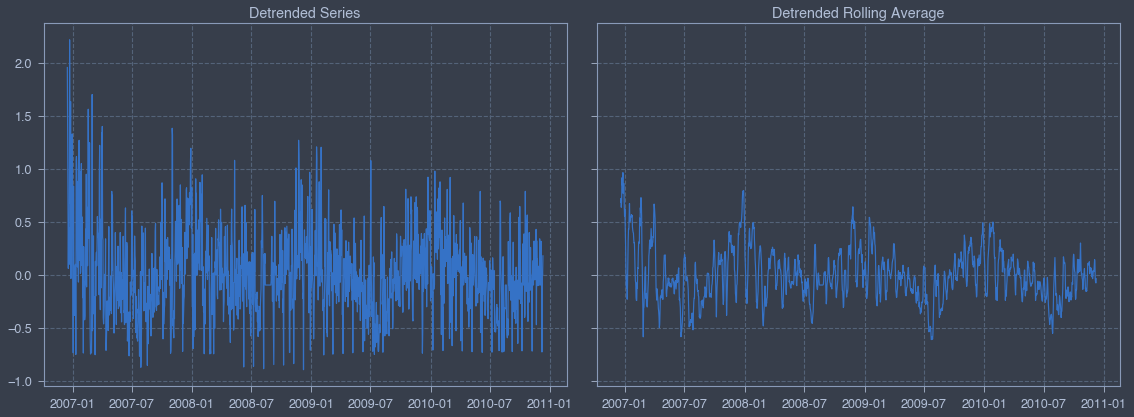

In [17]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset['DetrendedMetric'].loc[firstDayTrain:].dropna())
axes[0].set_title('Detrended Series')
axes[1].plot(dataset['DetrendedRolling'].loc[firstDayTrain:].dropna())
axes[1].set_title('Detrended Rolling Average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

## Fit Fourier Decomposition

In [18]:
y = dataset['DetrendedRolling'].loc[firstDayTrain:].dropna().loc['2009-01-01' : '2009-12-31']
x = y.index
xs = range(len(y))
z = y # already subtracted best fit

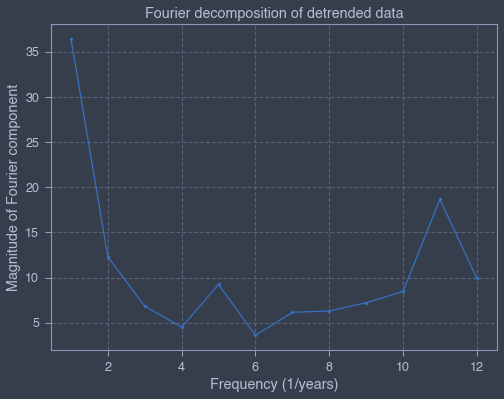

In [19]:
Z = np.fft.fft(z)
plt.figure(figsize=(8,6))
plt.plot(range(1, 13), np.abs(Z[1:13]))
plt.scatter(range(1, 13), np.abs(Z[1:13]), s=10)
plt.xlabel('Frequency (1/years)')
plt.ylabel('Magnitude of Fourier component')
#plt.grid()
_=plt.title('Fourier decomposition of detrended data')

In [20]:
def top_component_filter(Z, i, threshold=12):
    Z_filtered = Z.copy() # necessary to copy?  I don't want any side effects
    
    # kill high frequency components to avoid weekly seasonality dominating
    Z_filtered[range(threshold+1, len(Z_filtered))] = 0
    
    if i > 0:
        # This breaks for i==0, so need the condition
        inds = np.abs(Z_filtered).argsort()[:-i] # indices of all but top i weighted components
        Z_filtered[inds] = 0
    else:
        Z_filtered = np.zeros(Z.shape)
    
    return Z_filtered

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


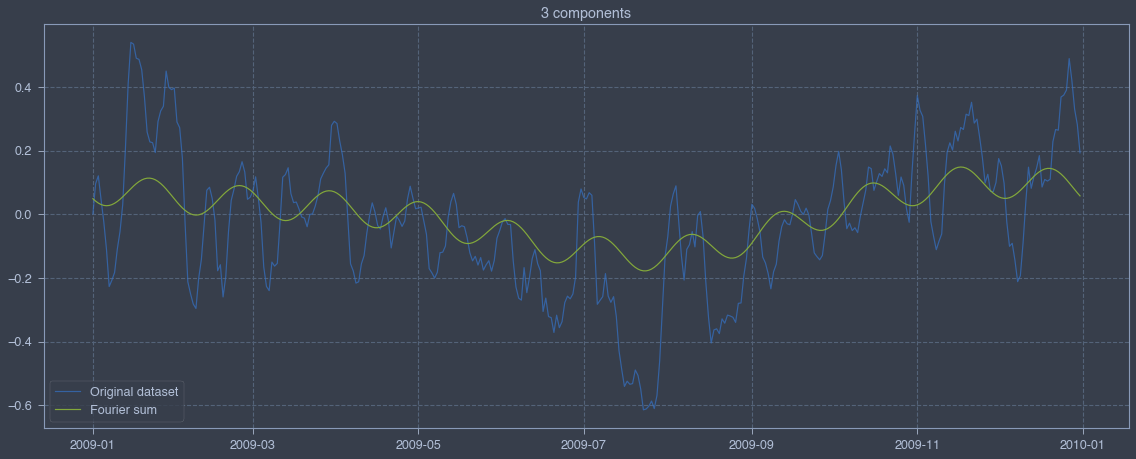

In [21]:
f, ax = plt.subplots(figsize=(16, 6.4))
plt.tight_layout()
num_components = 3
Z = np.fft.fft(z)
Z_filtered1 = top_component_filter(Z, num_components, threshold=12)
ifft1 = np.fft.ifft(Z_filtered1)
ax.plot(x, z, alpha=0.7, label="Original dataset")
ax.plot(x, ifft1, alpha=1, label='Fourier sum')
ax.set_title(str(num_components)+' components')
#ax.grid(linestyle='dashed')
ax.legend()

In [22]:
Z = np.fft.fft(z)
Z_filtered1 = top_component_filter(Z, 3, threshold=12)
ifft1 = np.fft.ifft(Z_filtered1)

In [23]:
df = pd.DataFrame(data={'FourierSum' : ifft1.real}, index=x)

In [24]:
def dateTimeToMonthDay(datetime_index):
    return datetime_index.map(lambda x: x.strftime('%m-%d'))

In [25]:
dataset['tmpMonthDay'] = dateTimeToMonthDay(dataset.index)

In [26]:
df['tmpMonthDay'] = dateTimeToMonthDay(df.index)

In [27]:
dataset = (dataset
           .reset_index()
           .merge(df,
                  left_on='tmpMonthDay',
                  right_on='tmpMonthDay',
                  how='left')
           .set_index('Date')
           .drop('tmpMonthDay', axis=1))

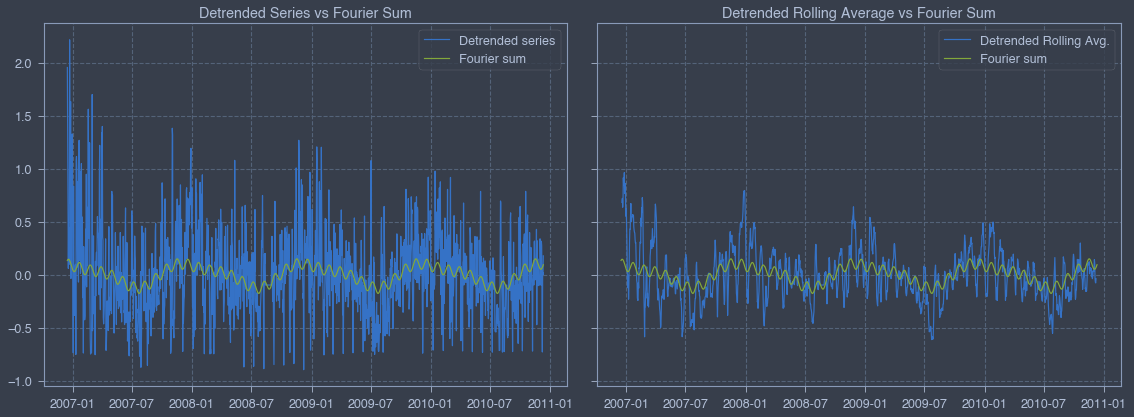

In [28]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'DetrendedMetric'],
             label='Detrended series')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'FourierSum'],
             label='Fourier sum')
axes[0].legend()
axes[0].set_title('Detrended Series vs Fourier Sum')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'DetrendedRolling'],
             label='Detrended Rolling Avg.')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'FourierSum'],
             label='Fourier sum')
axes[1].legend()
axes[1].set_title('Detrended Rolling Average vs Fourier Sum')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

In [29]:
dataset['NonSeasonal'] = dataset['DetrendedMetric'] - dataset['FourierSum']
dataset['NonSeasonalRolling'] = dataset['DetrendedRolling'] - dataset['FourierSum']

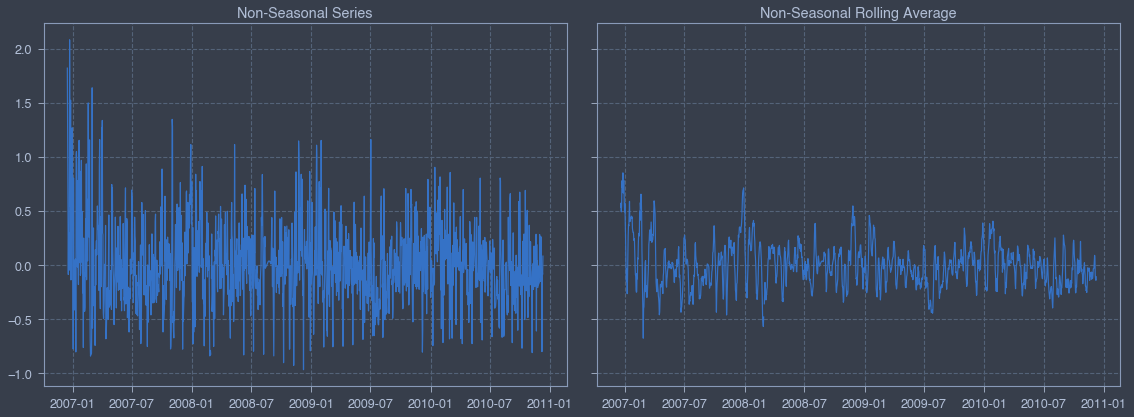

In [30]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'NonSeasonal'])
axes[0].set_title('Non-Seasonal Series')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'NonSeasonalRolling'])
axes[1].set_title('Non-Seasonal Rolling Average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

## Sliding Window Embedding

In [31]:
tsData = dataset.loc[firstDayTrain:, metric].dropna() # What is plotted above.  One null on 2008-02-29
smoothedTsData = dataset.loc[firstDayTrain:, 'RollingMetric'].dropna()

In [32]:
def slidingWindow(ts, nDim=3):
    r""" Sliding window from (N,)-array to (N - nDim + 1, nDim)-array """
    N = ts.shape[0]
    A = np.zeros((N - nDim + 1, nDim))
    
    for i in range(N - nDim + 1):
        A[i, :] = ts.values[i:i+nDim]
        
    return A

In [33]:
embeddedData = slidingWindow(tsData)
embeddedSmoothedData = slidingWindow(smoothedTsData)

### 3D Plots

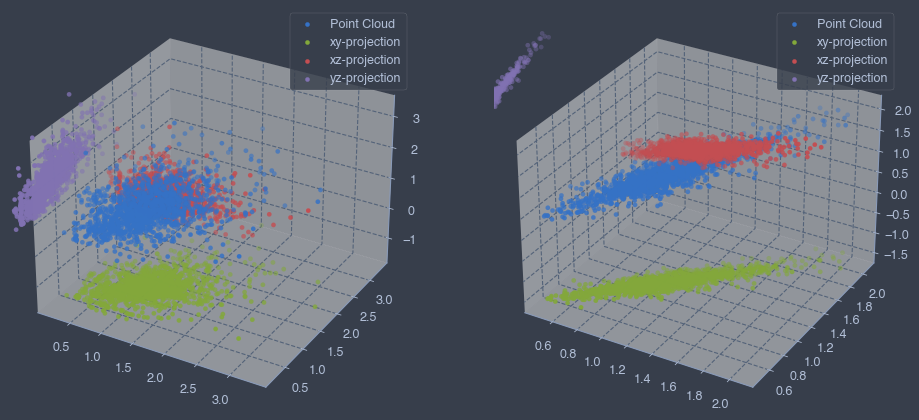

In [34]:
fig = plt.figure(figsize=(16,8))

for i, data in zip(range(2), [embeddedData, embeddedSmoothedData]):
    ax = fig.add_subplot(1, 2, i + 1, projection='3d')
    ax.scatter(
        data[:, 0],
        data[:, 1],
        data[:, 2],
        label='Point Cloud'
    )

    ax.scatter(
        data[:, 0],
        data[:, 1],
        zdir='z', zs=-1.5,
        label='xy-projection'
    )
    ax.scatter(
        data[:, 0],
        data[:, 2],
        zdir='y', zs=1.5,
        label='xz-projection'
    )
    ax.scatter(
        data[:, 1],
        data[:, 2],
        zdir='x', zs=-0.5,
        label='yz-projection'
    )

    ax.legend()

### Persistent Homology

In [35]:
# Try different dimensions
nDim = 3
embeddedData = slidingWindow(tsData, nDim=nDim)
embeddedSmoothedData = slidingWindow(smoothedTsData, nDim=nDim)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


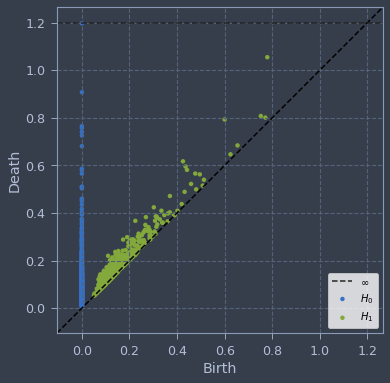

In [36]:
plt.figure(figsize=(10, 6))
rips = Rips(maxdim=1)
diagrams = rips.fit_transform(embeddedData)
#diagramsSmooth = Rips(maxdim=1).fit_transform(embeddedSmoothedData)
rips.plot(diagrams)